## Adam Packer and Aaron Newman (08-apacker-newmanar)
## SIADS 593 Final Report
## Winter 2023
## Predictive Analysis Notebook

# 0.1 - Import necessary modules

In [63]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings('ignore')

# 0.2 - Read in data previously compiled in Setup workbook

In [64]:
compiled_df = pd.read_pickle('Compiled_data.pkl')

compiled_df

,date,location,loc_code,carrier,p_origin,p_dest,passengers,cases,deaths
0,2020-03-01,USA,USA,ALL,34527687.0,34527687.0,34527687.0,184104.0,4199.0
1,2020-03-01,USA,USA,04Q,274.0,274.0,274.0,184104.0,4199.0
2,2020-03-01,USA,USA,09Q,26506.0,26506.0,26506.0,184104.0,4199.0
3,2020-03-01,USA,USA,1EQ,637.0,637.0,637.0,184104.0,4199.0
4,2020-03-01,USA,USA,1QQ,417.0,417.0,417.0,184104.0,4199.0
...,...,...,...,...,...,...,...,...,...
29474,2022-11-01,"Salt Lake City, UT",SLC,OO,167276.0,168875.0,336151.0,5559.0,23.0
29475,2022-11-01,"Salt Lake City, UT",SLC,SY,258.0,255.0,513.0,5559.0,23.0
29476,2022-11-01,"Salt Lake City, UT",SLC,TQ,0.0,2.0,2.0,5559.0,23.0
29477,2022-11-01,"Salt Lake City, UT",SLC,UA,11601.0,11734.0,23335.0,5559.0,23.0


# 0.3 - Show a national overview of the data plotted over time

To orient the reader for the predictive analysis to follow, this code displays the COVID-related deaths, reported cases, and air passenger counts from March 2020 through November 2022. Note the differences in scale for the three plots, and the various peaks and troughs in each.

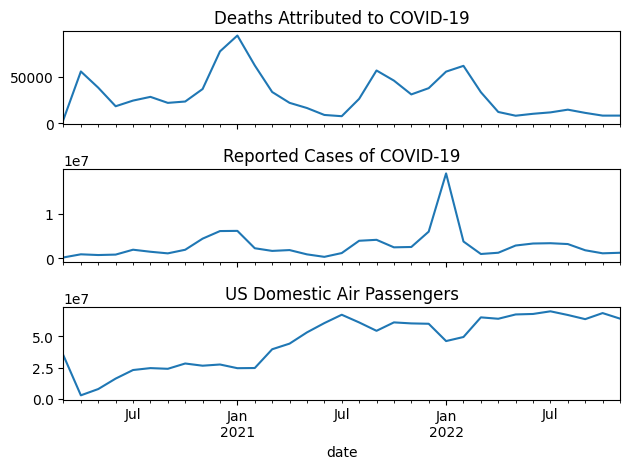

In [65]:
df_plot = compiled_df[(compiled_df.loc_code=='USA') & (compiled_df.carrier=='ALL')]
df_plot.index=df_plot.date
df_plot = df_plot[['passengers','cases','deaths']]
fig, axs = plt.subplots(3,1, sharex=True)
df_plot['deaths'].plot(ax=axs[0], title="Deaths Attributed to COVID-19")
df_plot['cases'].plot(ax=axs[1], title="Reported Cases of COVID-19")
df_plot['passengers'].plot(ax=axs[2], title="US Domestic Air Passengers")
plt.tight_layout()
plt.show()

# 1.0 - Linear Regression

This function uses scikit-learn to determine the fit of two series
to a Linear Regression. This does not account for the temporal nature of the data.<br>
<br><b><i>df</i></b> - the dataframe of data we want to compare
<br><b><i>covid_column</i></b> - "cases" or "deaths"
<br><b><i>numlag</i></b> - months of lag (allows 0 or 1)
<br><b><i>loc_code</i></b> - location code (3 characters)
<br><b><i>carrier</i></b> - air carrier code (2 or 3 characters)
<br><b><i>date_from</i></b> - date (yyyy-mm-dd) from which comparison should start<br><br>
The function returns the length of the series being compared and the R2 score for the regression.

In [66]:
import numpy as np
from sklearn.linear_model import LinearRegression

def get_lr_fit(df=compiled_df, covid_column="cases", numlag=0, 
               loc_code="USA", carrier="ALL", date_from='2020-01-01'):
    # Get relevant rows from dataframe based on location, carrier, and start date
    df_lr = df[(df.loc_code==loc_code) & (df.carrier==carrier) & (df.date>=date_from)].reset_index(drop=True)
    if numlag==0: # no lag
        X = np.array(df_lr[covid_column]).reshape(-1,1)
        y = df_lr['passengers']
    else: # one-month lag will reduce the series length by one
        X = np.array(df_lr[covid_column][1:]).reshape(-1,1)
        y = df_lr['passengers'].shift(1).dropna()

    reg = LinearRegression().fit(X, y)
    return len(X), reg.score(X, y)

Here, we look at linear regression fit from a national level.
This result is shown in Figure 5 in the final report.

In [67]:
fit_list=[]
for cc in ["cases", "deaths"]:
    for sd in ['2020-03-01','2022-01-01']:
        for lag in [0,1]:    
            ser_len, fit = get_lr_fit(covid_column=cc, numlag=lag, date_from=sd)
            fit_list.append([cc, sd, lag, ser_len, round(fit,3)])

df_fit = pd.DataFrame(fit_list, columns=['Type', 'Start Date', 'Lag', 'Series Length', 'R2 Score'])
df_fit

,Type,Start Date,Lag,Series Length,R2 Score
0,cases,2020-03-01,0,33,0.001
1,cases,2020-03-01,1,32,0.031
2,cases,2022-01-01,0,11,0.535
3,cases,2022-01-01,1,10,0.000
4,deaths,2020-03-01,0,33,0.215
5,deaths,2020-03-01,1,32,0.141
6,deaths,2022-01-01,0,11,0.826
7,deaths,2022-01-01,1,10,0.814


This next function uses scikit-learn to determine the fit and then score the prediction of
a Linear Regression. This does not account for the temporal nature of the data.<br>
<br><b><i>df</i></b> - the dataframe of data we want to compare
<br><b><i>covid_column</i></b> - "cases" or "deaths"
<br><b><i>numlag</i></b> - months of lag (allows 0 or 1)
<br><b><i>loc_code</i></b> - location code (3 characters)
<br><b><i>carrier</i></b> - air carrier code (2 or 3 characters)
<br><b><i>date_from</i></b> - date (yyyy-mm-dd) from which comparison should start
<br><b><i>test_rows</i></b> - number of rows to withhold for testing<br><br>
The function returns the R2 score for the prediction.

In [68]:
def get_lr_predict(df=compiled_df, covid_column="cases", numlag=0, 
                   loc_code="USA", carrier="ALL", date_from='2022-01-01', test_rows=2):
    # Get relevant rows from dataframe based on location, carrier, and start date
    df_lr = df[(df.loc_code==loc_code) & (df.carrier==carrier) & (df.date>=date_from)].reset_index(drop=True)
    if numlag==0: # no lag
        X = np.array(df_lr[covid_column]).reshape(-1,1)
        y = df_lr['passengers']
    else: # one-month lag will reduce the series length by one
        X = np.array(df_lr[covid_column][1:]).reshape(-1,1)
        y = df_lr['passengers'].shift(1).dropna()
        
    # Create train and test sets
    X_train, X_test = X[:len(X)-2], X[len(X)-2:]
    y_train, y_test = y[:len(y)-2], y[len(y)-2:]
    
    reg = LinearRegression().fit(X_train, y_train)
    return reg.score(X_test, y_test)

In [69]:
# Here, we look at the score for what should be the most promising prediction
# using deaths data from 2022 only. The results are not promising.
get_lr_predict(covid_column="deaths", numlag=0)

-0.7791296924051516

# 2.0 - Vector Auto Regression (VAR)

Procedures for fitting and running predictions with a VAR model were adapted from a tutorial provided on the Machine Learning Plus website here: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/.

## 2.1 - National-Level Prediction

We'll start with national data, using the same dataframe from Section 0.3 above. This time, we will split the data into a training and a test set (withholding the last six months of data for testing).

In [114]:
nobs = 6
df_train, df_test = df_plot[0:-nobs], df_plot[-nobs:]

We run a test to determine the appropriate order (how many lags) for the VAR model.

In [70]:
model = VAR(df_train)
x = model.select_order(maxlags=3)
x.summary()

,AIC,BIC,FPE,HQIC
0,83.38,83.53,1.634e+36,83.42
1,80.37,80.96,8.090e+34,80.53
2,79.88*,80.91*,5.166e+34*,80.15*
3,79.95,81.42,6.195e+34,80.34


Based on the above, we will fit the model with two lags and look at the results.

In [71]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Feb, 2023
Time:                     16:36:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    80.9012
Nobs:                     25.0000    HQIC:                   80.1613
Log likelihood:          -1083.89    FPE:                5.13233e+34
AIC:                      79.8774    Det(Omega_mle):     2.44728e+34
--------------------------------------------------------------------
Results for equation passengers
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const           8935157.606200   3927278.592493            2.275           0.023
L1.passengers         0.585055         0.167583            3.491           0.000
L1.cases             -0.325223         0.343617        

Since the model uses two lags, we need to grab the last two rows of the training data in order to prime the prediction for the testing timeframe. Then we perform the forecast.

In [72]:
forecast_input = df_train.values[-2:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_plot.index[-nobs:], columns=df_plot.columns)
df_forecast

,passengers,cases,deaths
date,,,
2022-06-01,6.577042e+07,4.485347e+06,22863.886094
2022-07-01,6.337973e+07,5.126494e+06,38277.978283
2022-08-01,6.213264e+07,5.076700e+06,44573.224364
2022-09-01,6.251630e+07,4.738786e+06,42246.887190
2022-10-01,6.395441e+07,4.427642e+06,36762.889230
2022-11-01,6.546735e+07,4.330476e+06,32903.258876


Let's plot the results against our original data.

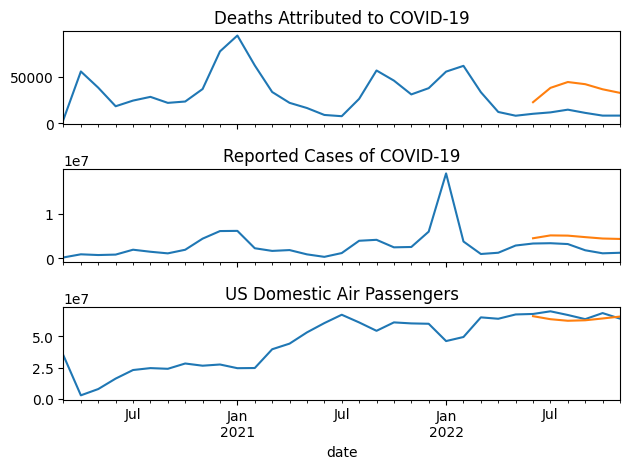

In [74]:
fig, axs = plt.subplots(3,1, sharex=True)
df_plot['deaths'].plot(ax=axs[0], title="Deaths Attributed to COVID-19")
df_forecast['deaths'].plot(ax=axs[0])
df_plot['cases'].plot(ax=axs[1], title="Reported Cases of COVID-19")
df_forecast['cases'].plot(ax=axs[1])
df_plot['passengers'].plot(ax=axs[2], title="US Domestic Air Passengers")
df_forecast['passengers'].plot(ax=axs[2])

plt.tight_layout()
plt.show()

The function takes a dataframe with forecast results and compares it to a dataframe of actuals (test data). It calculates a series of metrics, including:<br>
&nbsp;&nbsp;&nbsp;&nbsp;Mean Absolute Percentage Error<br>
&nbsp;&nbsp;&nbsp;&nbsp;Mean Error<br>
&nbsp;&nbsp;&nbsp;&nbsp;Mean Absolute Error<br>
&nbsp;&nbsp;&nbsp;&nbsp;Mean Percentage Error<br>
&nbsp;&nbsp;&nbsp;&nbsp;Root Mean Squared Error<br>
<br><b><i> forecast </i></b> - the dataframe containing the forecast values from a modeling activity
<br><b><i> actual </i></b> - the dataframe containing the test data with actual values

In [86]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

metrics_list=[]

for col in df_plot.columns:
    accuracy_prod = forecast_accuracy(df_forecast[col].values, df_test[col])
    accuracy_prod['variable']=col
    metrics_list.append(accuracy_prod)
    
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_metrics = pd.DataFrame(metrics_list)
df_metrics.index = df_metrics.variable
df_metrics.drop('variable', axis=1, inplace=True)
df_metrics

,mape,me,mae,mpe,rmse
variable,,,,,
passengers,0.05,-2694845.93,3242777.16,-0.04,3770369.85
cases,1.44,2365055.40,2365055.40,1.44,2495145.98
deaths,2.40,25379.85,25379.85,2.40,26112.89


## 2.2 - Market and Carrier-Level Prediction

Finally, let's see if VAR predictions work as well at the market level as they seem to at the national level. We define a function to make a prediction for a given market and/or carrier, returning a dataframe with accuracy metrics. The function also calls another function to plot the predictions against the actual data.

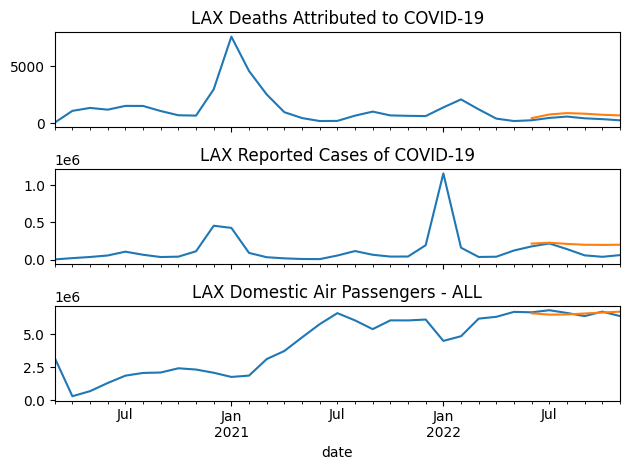

,mape,me,mae,mpe,rmse
variable,,,,,
passengers,0.03,-9493.85,187752.88,-0.00,219390.25
cases,1.61,93227.86,93227.86,1.61,109199.98
deaths,0.90,334.98,334.98,0.90,344.89


In [113]:
def plot_results(df_plot, df_forecast, loc_code="USA", carrier="ALL"):
    fig, axs = plt.subplots(3,1, sharex=True)
    df_plot['deaths'].plot(ax=axs[0], title=loc_code + " Deaths Attributed to COVID-19")
    df_forecast['deaths'].plot(ax=axs[0])
    df_plot['cases'].plot(ax=axs[1], title=loc_code + " Reported Cases of COVID-19")
    df_forecast['cases'].plot(ax=axs[1])
    df_plot['passengers'].plot(ax=axs[2], title=loc_code + " Domestic Air Passengers - " + carrier)
    df_forecast['passengers'].plot(ax=axs[2])
    plt.tight_layout()
    plt.show()

def predict_market(df=compiled_df, loc_code="USA", carrier="ALL", nobs=6):
    df_market = df[(df.loc_code==loc_code) & (df.carrier==carrier)]
    df_market.index = df_market.date
    df_market = df_market[['passengers', 'cases', 'deaths']]
    df_train, df_test = df_market[0:-nobs], df_market[-nobs:]
    
    model = VAR(df_train)
    model_fitted = model.fit(2)
    forecast_input = df_train.values[-2:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df_market.index[-nobs:], columns=df_market.columns)
    
    plot_results(df_market, df_forecast, loc_code, carrier)
    
    metrics_list=[]

    for col in df_market.columns:
        accuracy_prod = forecast_accuracy(df_forecast[col].values, df_test[col])
        accuracy_prod['variable']=col
        metrics_list.append(accuracy_prod)
    df_metrics = pd.DataFrame(metrics_list)
    df_metrics.index = df_metrics.variable
    df_metrics.drop('variable', axis=1, inplace=True)
    return(df_metrics)

metrics = predict_market(loc_code="LAX", carrier="ALL")

metrics.head()